# Using an Image Classification Neural Network to Identify Various Sports
I used the fastai library to work with the data as well as tune the neural networks (both resnet34 and resnet50 arhcitectures were used). The data was scraped from the top 200 Google Images search results for action shots of each sport.

These were the sports used:


1.   Baseball
2.   Basketball
3. Cricket
4. Curling
5. Golf
6. Hockey
7. Rugby
8. Soccer
9. Tennis
10. Volleyball





## Initial Steps
Here are some basic commands to set up and import the required libraries, as well as set some Jupyter notebook properties.



In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

## Working With The Dataset

Some basic commands were used to download all the images linked in the CSV files, as well as create seperate folders containing the images corresponding to each class.




In [0]:
classes = ['baseball','basketball','cricket','curling','golf','hockey','rugby','soccer','tennis','volleyball']
path = Path('/content/data/sports')
origin = Path('/content')

In [0]:
for c in classes:
  folder = c
  file = c + '.csv'
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(origin/file, dest, max_pics=200)


Once the images were all downloaded and sorted, the following code was used to verify that the images could be successfully opened. Images which didn't work properly were deleted.

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

The following code was used to normalize the images to resemble the images used in ImageNet. This is because I used transfer learning for the neural networks, with the initial layers having values learned from images in that dataset.

The validation set is created by randomly choosing 20% of the images from the total dataset (`valid_pct = 0.2`). Calling 
`
np.random.seed(42)
`
ensures that the same validation set is selected each time this code is run.


In [0]:
np.random.seed(42) 
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Simple commands were used to preview the images in the dataset, as well as looking at stats for the dataset.

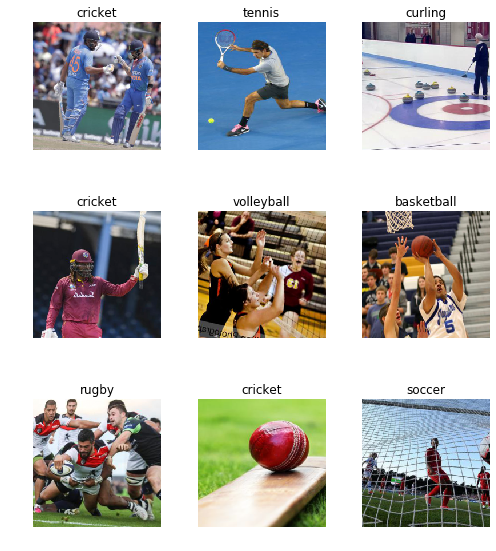

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['baseball',
  'basketball',
  'cricket',
  'curling',
  'golf',
  'hockey',
  'rugby',
  'soccer',
  'tennis',
  'volleyball'],
 10,
 1385,
 346)

## Training The Model

### Resnet34

First, a resnet34 was created and trained on the data for a total of 4 epochs. The end result was a model with an error rate of slightly over 15%.


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.068536,0.814194,0.248555,00:20
1,1.225738,0.547792,0.164740,00:20
2,0.853739,0.508939,0.164740,00:20
3,0.654201,0.504859,0.153179,00:20


In [0]:
learn.save('stage-1')

In order to see what images were proving most troublesome for the network, the top losses were plotted, and a confusion matrix was generated. A quick glance through the top losses shows that a major issue for this neural network would be the poor quality of the dataset, with many misleading and/or vague images.

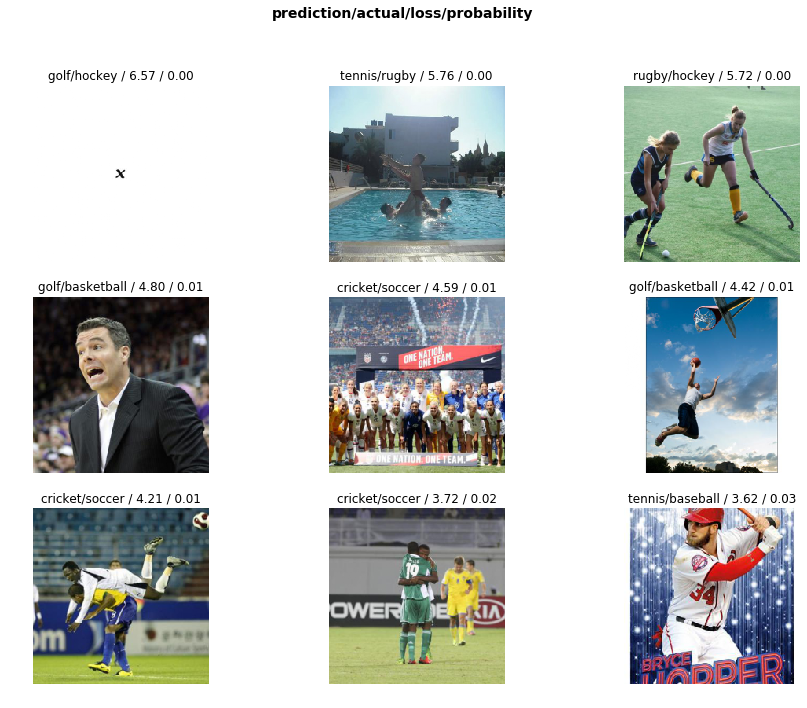

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

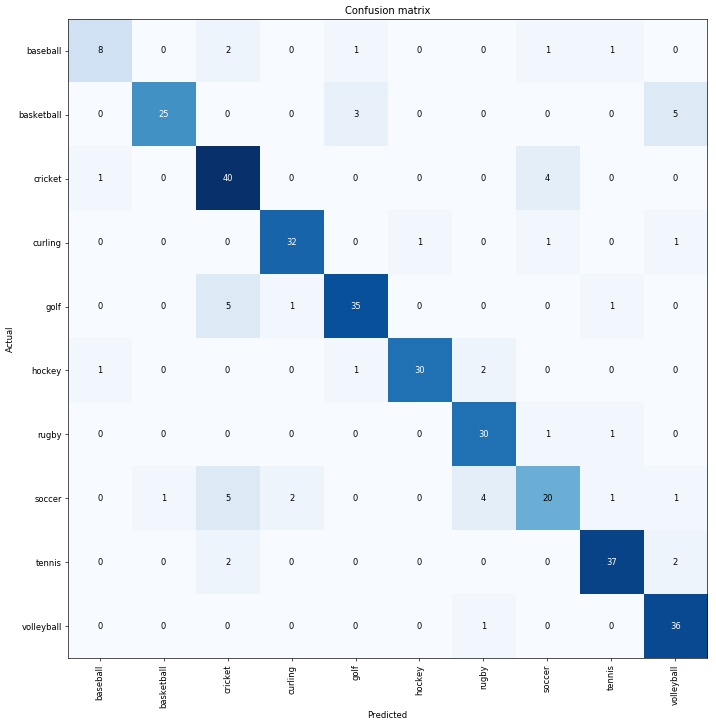

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In order to try and improve performance on this dataset in particular, the top layers of the resnet34, which were learned from the ImageNet data, were unfrozen. Based on the learning rate plot, new learning rate values were chosen such that the top layers were adjusted very slowly, while the bottom layers were more quickly adjusted. Unfortunately, it didn't seem to make a notable difference, as the error rate was still hovering around the 15% mark despite more training.

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


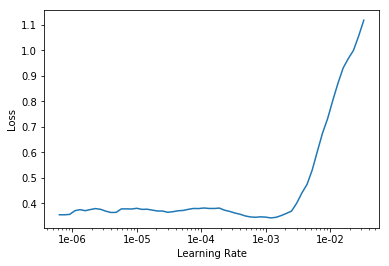

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.402712,0.481725,0.150289,00:20
1,0.336574,0.456830,0.141618,00:20


In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.263018,0.459876,0.150289,00:20
1,0.251892,0.453173,0.156069,00:20
2,0.241755,0.453110,0.150289,00:20
3,0.243422,0.446781,0.150289,00:20


In [0]:
learn.save('stage-1-tweaked')

### Resnet50

Since the error rate performance of the resnet34 appeared to be stuck in a local minimum, a change of approach seemed like a good idea. I tried using a resnet50 for better performance, and it immediately got an error rate under 15% (slightly over 13%).

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.429375,0.558073,0.173410,00:22
1,0.832581,0.460357,0.135838,00:21
2,0.568728,0.447017,0.132948,00:21
3,0.426187,0.432783,0.132948,00:21


Unfortunately, further tweaking by unfreezing the top layers of the network and training the model over more epochs didn't appear to help much, as the error rate performance of the network appeared to converge around 10.5%.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


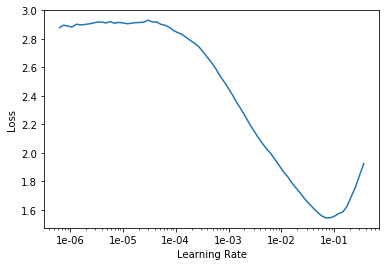

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.235654,0.423690,0.130058,00:22
1,0.209814,0.399106,0.124277,00:22
2,0.191367,0.400036,0.118497,00:22


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


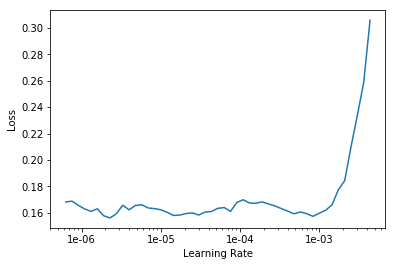

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save('stage-1-50')

In [0]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.169329,0.393814,0.121387,00:22
1,0.168529,0.383454,0.124277,00:23
2,0.164298,0.378227,0.109827,00:23
3,0.154445,0.370883,0.115607,00:22
4,0.140508,0.360921,0.112717,00:22
5,0.123595,0.359707,0.104046,00:23
6,0.118254,0.360304,0.109827,00:22
7,0.110108,0.358837,0.104046,00:22


Plotting some of the images which were incorrectly classified showed that a lot (but not all) of the mistakes were simply due to bad images which a human likely couldn't use to predict the sport either (for example, an image of a team celebrating a victory at a tournament).

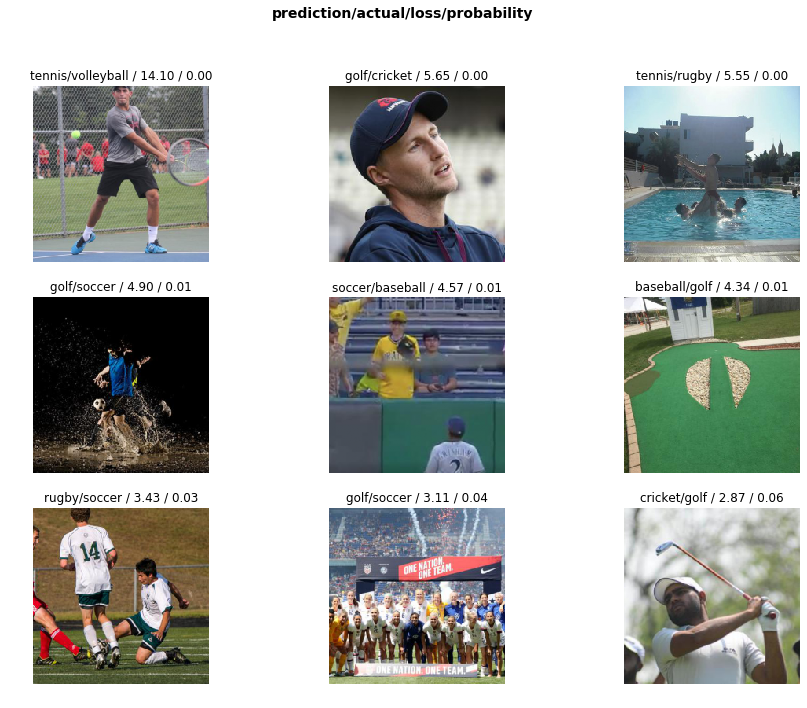

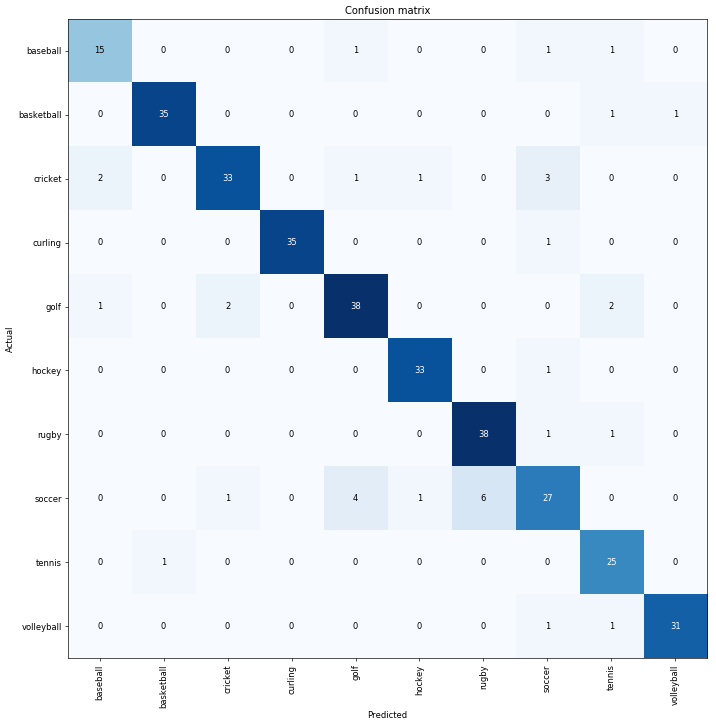

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



## Next Steps
Since a major issue with the performance of these models appeared to be with poor images in the dataset, I decided to manually collect images (to make sure they were all at least somewhat representative of the sport being played) and try again.